# MAGPRIME Tutorial notebook
This notebook provides a hands-on tutorial for using the MAGPRIME Python library to clean and process magnetometer data. MAGPRIME implements several state-of-the-art algorithms for removing noise and interference from magnetometer measurements.

In this tutorial, we will cover:

* Loading sample magnetometer data from the QSZ-1 Japanese GNSS Satellite.
* Visualizing and assessing the raw data
* Preprocessing steps like detrending, filtering, etc.
* Applying MAGPRIME's noise removal algorithms:
    * Independent Component Analysis (ICA)
    * Multivariate Singular Spectrum Analysis (MSSA)
    * Gradiometry 
    * Principal Component Gradiometry
    * SHEINKER
    * Frequency-Based Gradiometry
    * Underdetermined Blind Source Separation (UBSS)
    * Wavelet-Adaptive Interference Cancellation for Underdetermined Platforms (WAIC-UP)
* Comparing noise removal performance

The goal is to demonstrate a typical workflow using MAGPRIME to clean real-world magnetometer data. The noise removal methods in MAGPRIME were designed to handle issues like sensor noise, environmental interference, and more. By the end of this tutorial you should have a good understanding of how to leverage MAGPRIME for your own projects.

Let's get started!

### Load data from Michibiki-1 Magnetometers
In this notebook, we will use noisy magnetometer data from the [Michibiki-1 satellite](https://sees.tksc.jaxa.jp/fw/dfw/SEES/English/Papers/data/2020/peer_reviewed/01/2020_reviewed_01.shtml). This data is featured in Imajo et al. (2021) to showcase the use of ICA to clean magnetometer data. 

The code first imports NumPy for numerical processing and Matplotlib for plotting. It then loads the raw biased Michibiki-1 magnetometer data from a .dat file into a matrix called B_qzs. The known bias values are subtracted from each sensor axis.

Since some algorithms like UBSS and MSSA are computationally intensive, the data is decimated to 0.1 Hz to speed up processing.

Matplotlib is used to create a figure with two columns of subplots to visualize the data. The left column overlays the data from the two magnetometer sensors MAM-S1 and MAM-S2 for each axis. The right column plots the difference between the sensors.

This plot shows the noisy nature of the data, with interference patterns clearly visible. The sensor disagreement is also apparent in the difference plots.

c:\ProgramData\Anaconda3\lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


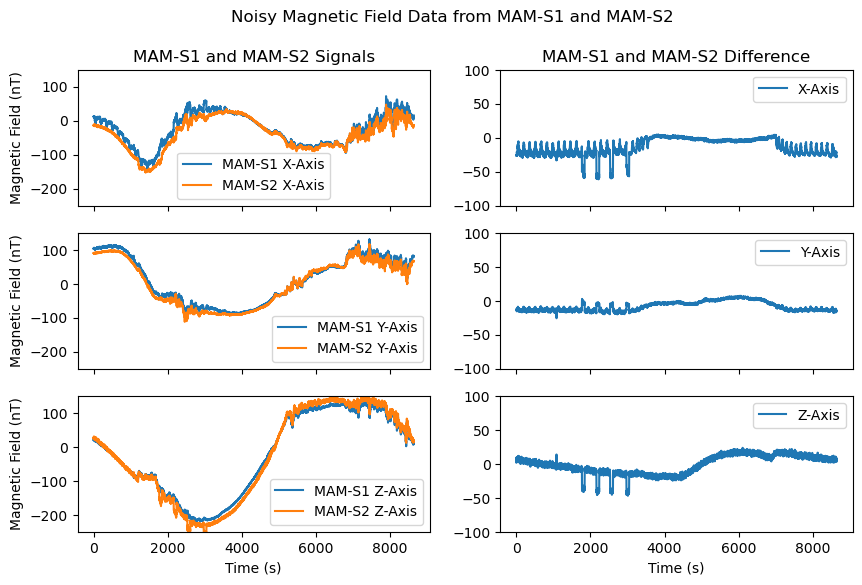

In [1]:
"Import the necessary modules"
from magprime import utility
import numpy as np
import matplotlib.pyplot as plt


B = utility.load_michibiki_data() # shape = (n_sensor, n_axis, n_samples)

"Decimate the data to 0.1 Hz because UBSS and MSSA are slow methods and it will take a long time to run on 86,400 data points"
B = B[:,:,::10]

"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B[0,0], label="MAM-S1 X-Axis")
axs[0,0].plot(B[1,0], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B[0,1], label="MAM-S1 Y-Axis")
axs[1,0].plot(B[1,1], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B[0,2], label="MAM-S1 Z-Axis")
axs[2,0].plot(B[1,2], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend()
axs[0,1].set_ylim(-100, 100)

axs[1,1].plot(B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend()
axs[1,1].set_ylim(-100, 100)

axs[2,1].plot(B[1,2]-B[0,2], label="Z-Axis")
axs[2,1].set_ylim(-100, 100)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()



### Independent Component Analysis
Independent Component Analysis (ICA) is a blind source separation method that leverages the statistical independence of signals to separate the true geomagnetic field from noise sources in magnetometer data. It first detrends and preprocesses the data. The ICA algorithm then decomposes the data into independent components. To identify the natural magnetic field, it selects the ICs that have the lowest correlation with the difference between sensors, under the assumption ambient fields produce consistent signals. These ICs are used to reconstruct the denoised data. 

A summary of each algorithm and its parameters can be seen through calling

`help(algorithm)`

In [2]:
from magprime.algorithms import ICA
help(ICA)

Help on module magprime.algorithms.ICA in magprime.algorithms:

NAME
    magprime.algorithms.ICA

DESCRIPTION
    Author: Shun Imajo, Alex Hoffmann
    Last Update: 9/19/2023
    Description: This file implements a noise removal method using independent component
                 analysis (ICA) for magnetic field data from multiple magnetometers. 
                 The method follows the approach of Imajo et al. (2021). The method 
                 separates the noise components from the signal components based on 
                 their statistical independence and non-Gaussianity. The natural magnetic 
                 field components are then identified by their similarity in the mixing
                 matrix (ica.mixing_).
                 
    General Parameters
    ----------
    uf : window size for uniform filter used to detrend the data
    detrend : boolean for whether to detrend the data

FUNCTIONS
    clean(B, triaxial=True)
        B: magnetic field measurements from the 

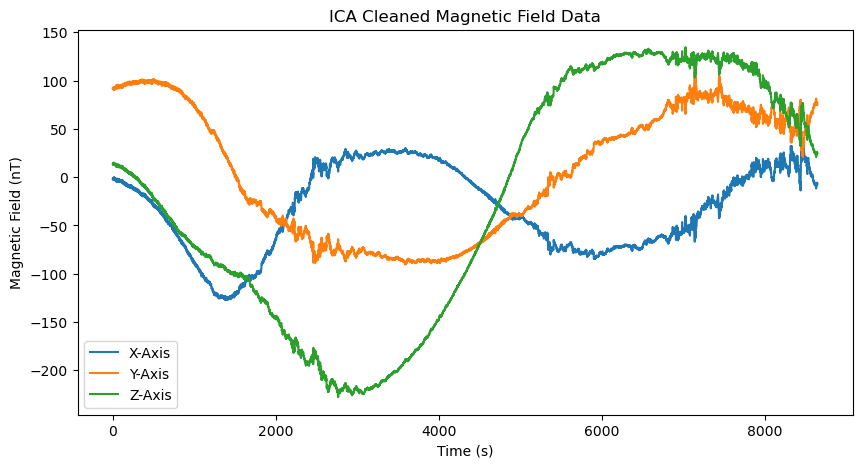

In [3]:
"Set Detrend to True and Uniform Filter Size used to remove the DC component"
ICA.detrend = True
ICA.uf = 800

"Clean the data"
B_ica = ICA.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.title("ICA Cleaned Magnetic Field Data")
plt.plot(B_ica[0], label="X-Axis")
plt.plot(B_ica[1], label="Y-Axis")
plt.plot(B_ica[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.show()


### Frequency-based Gradiometry (Ream et al. 2021)
Todo: Explanation

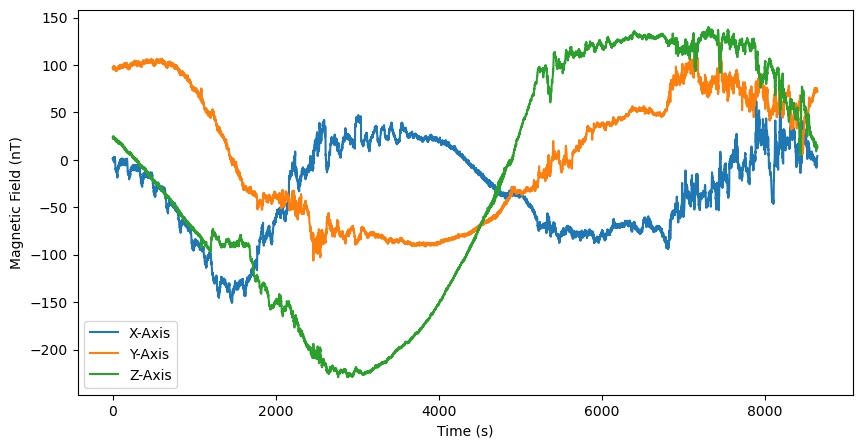

In [4]:
from magprime.algorithms import REAM

"Detrend the data"
REAM.detrend = True
REAM.uf = 360

"Algorithm Parameters"
REAM.delta_B = 3
REAM.n = 20
REAM.p = 98

"Clean the data"
B_ream = REAM.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_ream[0], label="X-Axis")
plt.plot(B_ream[1], label="Y-Axis")
plt.plot(B_ream[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()

### SHEINKER
Todo Explanation

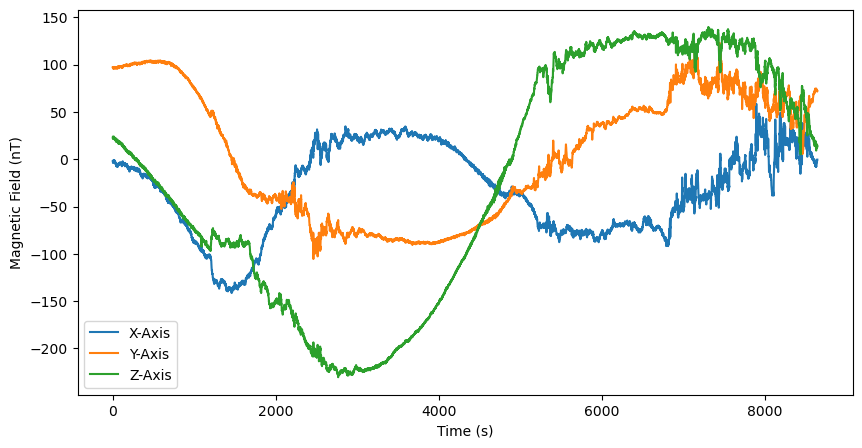

In [5]:
from magprime.algorithms import SHEINKER

"Detrend the data"
SHEINKER.uf = 800
SHEINKER.detrend = True

"Clean the data"
B_sheinker = SHEINKER.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_sheinker[0], label="X-Axis")
plt.plot(B_sheinker[1], label="Y-Axis")
plt.plot(B_sheinker[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()


### Principal Component Gradiometry (PiCoG)

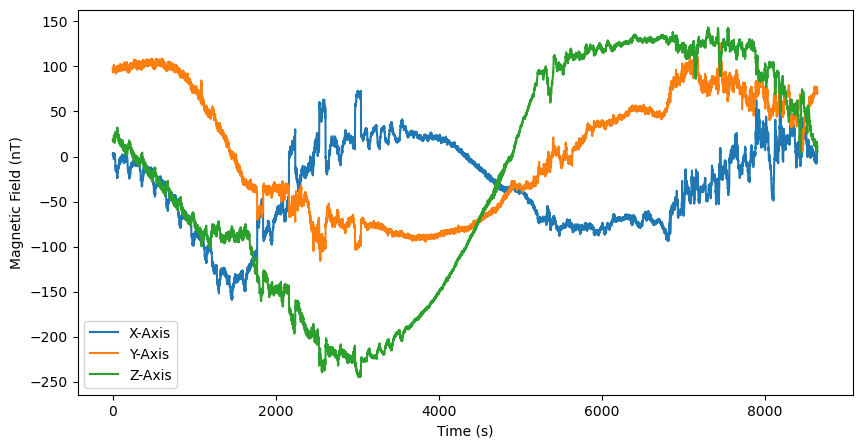

In [6]:
from magprime.algorithms import PiCoG

"Detrend the data"
PiCoG.uf = 800
PiCoG.detrend = True

"Clean the data"
B_picog = PiCoG.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_picog[0], label="X-Axis")
plt.plot(B_picog[1], label="Y-Axis")
plt.plot(B_picog[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()



### WAIC-UP 
Todo Explanation
(Hoffmann and Moldwin, 2023)

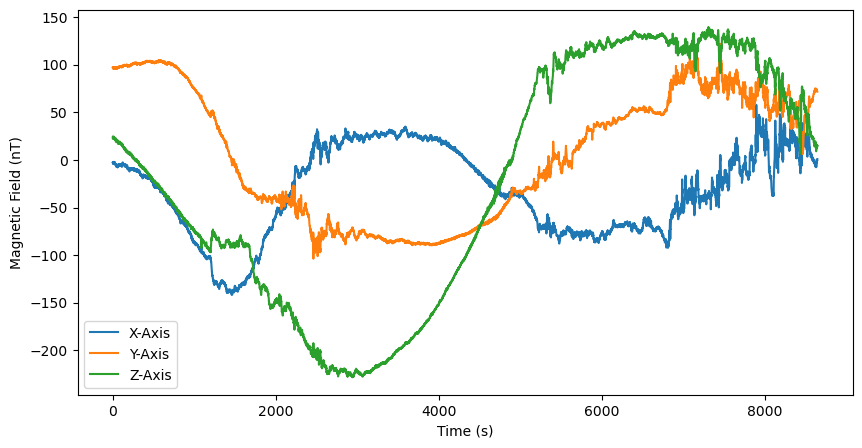

In [8]:
from magprime.algorithms import WAICUP

"Detrend the data"
WAICUP.uf = 360
WAICUP.detrend = True
WAICUP.lowest_freq = .5/86400

"Algorithm Parameters"
WAICUP.fs = .1
WAICUP.dj = 1/12

"Clean the data"
B_waicup = WAICUP.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_waicup[0], label="X-Axis")
plt.plot(B_waicup[1], label="Y-Axis")
plt.plot(B_waicup[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()


### Multichannel Singular Spectrum Analysis
Todo Explanation

In [23]:
from magprime.algorithms import MSSA

"Detrend the data"
MSSA.uf = 360
MSSA.detrend = True

"Algorithm Parameters"
MSSA.window_size = 360
MSSA.alpha = 0.05


"Clean the data"
B_mssa = MSSA.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_mssa[0], label="X-Axis")
plt.plot(B_mssa[1], label="Y-Axis")
plt.plot(B_mssa[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()

### Underdetermined Blind Source Separation
Todo Explanation

100%|██████████| 9208/9208 [02:25<00:00, 63.12it/s]


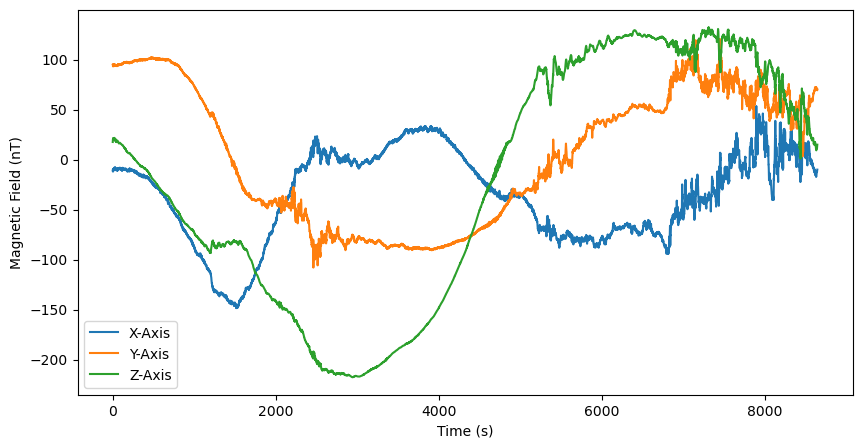

In [ ]:
from magprime.algorithms import UBSS

"Detrend the data"
UBSS.detrend = False

"Algorithm Parameters"
UBSS.sigma = 10
UBSS.fs = .1
UBSS.cs_iters = 2
UBSS.bpo = 5

"Clean the data"
B_ubss = UBSS.clean(np.copy(B), triaxial=True)

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_ubss[0], label="X-Axis")
plt.plot(B_ubss[1], label="Y-Axis")
plt.plot(B_ubss[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()



### Ness Gradiometry
Todo Explanation

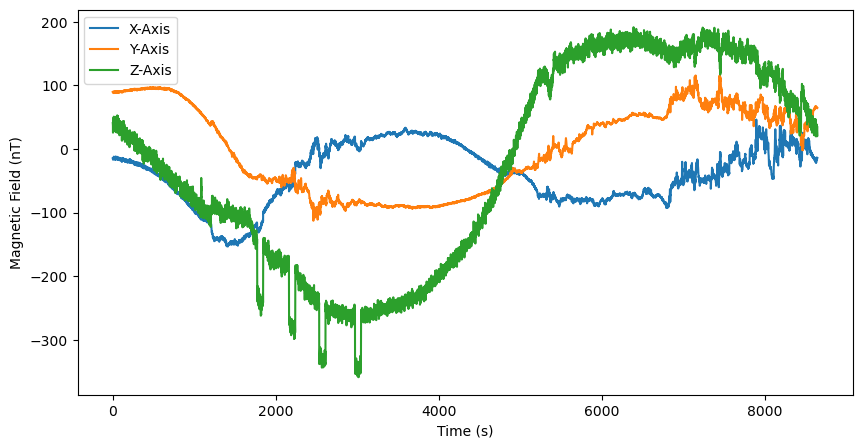

In [11]:
from magprime.algorithms import NESS
from magprime.utility import calculate_coupling_coefficients


"Algorithm Parameters"
NESS.aii = calculate_coupling_coefficients(B, fs = 0.1, sspTol=20)

"Clean the data"
B_ness = NESS.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_ness[0], label="X-Axis")
plt.plot(B_ness[1], label="Y-Axis")
plt.plot(B_ness[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()



### Ness M-SSA
Todo Explanation

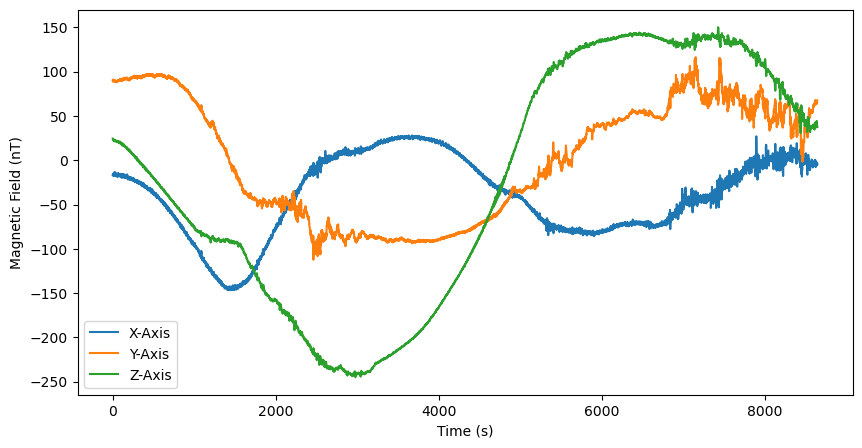

In [12]:
from magprime.algorithms import NESSA
from magprime.utility import calculate_coupling_coefficients


"Detrend the data"
NESSA.uf = 360
NESSA.detrend = True

"Algorithm Parameters"
NESSA.window_size = 360
NESSA.alpha = 0.05
NESSA.aii = calculate_coupling_coefficients(B, fs = 0.1, sspTol=20)

"Clean the data"
B_nessa = NESSA.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_nessa[0], label="X-Axis")
plt.plot(B_nessa[1], label="Y-Axis")
plt.plot(B_nessa[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()